## Tweets text analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
import re
import string
from text_stats_transformer import TextStatsTransformer

In [2]:
df_train = pd.read_csv('./train-dataset.csv', index_col='id')
df_train.head()

,keyword,location,text,target
id,,,,
8783,siren,"Honolulu,Hawaii",Serephina the Siren &lt;3 http://t.co/k6UEtsnLHT,0
3335,demolished,NaN,Take this China get demolished and sent back t...,0
2811,cyclone,Rural Northern Nevada,@mccauleysdesign @abysmaljoiner @DyamiPlotke i...,0
3381,demolition,"Atlantic, IA",Last chance to work at the old FFA foodstand a...,0
5540,flattened,NaN,Would've been great if Mbiwa just flattened th...,0


In [3]:
negative_count = sum(df_train['target'] == 0)
positive_count = sum(df_train['target'] == 1)
n_samples = df_train.shape[0]
negative_prop = negative_count / n_samples
positive_prop = positive_count / n_samples 
print(f'All samples: {n_samples}, negative: {100*negative_prop:.1f}%, positive: {100*positive_prop:.1f}%')


All samples: 6851, negative: 57.1%, positive: 42.9%


Negative/positive labels are not equally distributed in test dataset, but it's acceptable level

In [4]:
tr = TextStatsTransformer()


In [5]:
sample = df_train.sample(n=15)

In [6]:
def increment_by_target(target, item):
    negative, positive = item
    if target:
        positive += 1
    else:
        negative += 1
    return (negative, positive)


def analyze(data, train=True):
    clean_tokens_dict = {}
    stop_word_tokens_dict = {}
    all_word_tokens_dict = {}
    punctuation_dict = {}
    tweet_tokens = []
    tweet_stopwords = []
    tweet_punctuations = []
    tweet_all_word_tokens = []
    for _, row in data.iterrows():
        original_text = row['text'].lower()
        target = int(row['target']) if train else False
        tokens = tr.clean_text(original_text, lemmatize=True, skip_stop_words=False, return_array=True)
        punctuations = tr.extract_punctuation(original_text)
        clean_tokens = []
        stop_word_tokens = []
        for t in tokens:
            if tr.is_not_stopword(t):
                if len(t) >= 3:
                    clean_tokens.append(t)
            else:
                stop_word_tokens.append(t)  
        if train:          
            for t in clean_tokens:
                item = increment_by_target(target, clean_tokens_dict.get(t, (0, 0)))
                clean_tokens_dict[t] = item
            for t in stop_word_tokens:
                item = increment_by_target(target, stop_word_tokens_dict.get(t, (0, 0)))
                stop_word_tokens_dict[t] = item
            for t in tokens:
                item = increment_by_target(target, all_word_tokens_dict.get(t, (0, 0)))
                all_word_tokens_dict[t] = item
            for punc in punctuations:
                item = increment_by_target(target, punctuation_dict.get(punc, (0, 0)))
                punctuation_dict[punc] = item

        tweet_tokens.append(clean_tokens)
        tweet_stopwords.append(stop_word_tokens)
        tweet_all_word_tokens.append(tokens)
        tweet_punctuations.append(punctuations)
    
    if train:
        clean_tokens = []
        clean_tokens_keys = []
        for key, value in clean_tokens_dict.items():
            neg, pos = value
            clean_tokens_keys.append(key)
            clean_tokens.append((neg, pos))
        df_tokens = pd.DataFrame(data=clean_tokens, columns=['negative_count', 'positive_count'], index=clean_tokens_keys)
        
        stop_words_stat = []
        stop_words_keys = []
        for key, value in stop_word_tokens_dict.items():
            neg, pos = value
            stop_words_keys.append(key)
            stop_words_stat.append((neg, pos))
        df_stop_words = pd.DataFrame(data=stop_words_stat, columns=['negative_count', 'positive_count'], index=stop_words_keys)

        all_word_tokens_stat = []
        all_word_tokens_keys = []
        for key, value in all_word_tokens_dict.items():
            neg, pos = value
            all_word_tokens_keys.append(key)
            all_word_tokens_stat.append((neg, pos))
        df_all_word_tokens = pd.DataFrame(data=all_word_tokens_stat, columns=['negative_count', 'positive_count'], index=all_word_tokens_keys)

        punctuation_stat = []
        punctuation_keys = []
        for key, value in punctuation_dict.items():
            neg, pos = value
            punctuation_keys.append(key)
            punctuation_stat.append((neg, pos))
        df_punctuation = pd.DataFrame(data=punctuation_stat, columns=['negative_count', 'positive_count'], index=punctuation_keys)

    data['clean_tokens'] = tweet_tokens
    data['stop_words'] = tweet_stopwords
    data['word_tokens'] = tweet_all_word_tokens
    data['punctuation'] = tweet_punctuations

    if train:
        return df_tokens, df_stop_words, df_all_word_tokens, df_punctuation
    return None

In [7]:
df_tokens, df_stop_words, df_all_word_tokens, df_punctuation = analyze(df_train)

Skip very rare tokens

In [8]:
df_tokens = df_tokens.query('negative_count > 10 and positive_count > 10')

Calculate tokens frequency in negative and positive tweets

In [9]:

df_tokens['count_sum'] = df_tokens['negative_count'] + df_tokens['positive_count']

# adjust frequency coefficients according to negative/positive tweets representation in the dataset
df_tokens['negative_count_adj'] = df_tokens['negative_count'] / negative_prop
df_tokens['positive_count_adj'] = df_tokens['positive_count'] / positive_prop

tokens_freq_scaler = MinMaxScaler()
tokens_freq_scaled = tokens_freq_scaler.fit_transform(df_tokens[['negative_count_adj', 'positive_count_adj']])

df_tokens['negative_scaled'] = tokens_freq_scaled[:,0]
df_tokens['positive_scaled'] = tokens_freq_scaled[:,1]

df_tokens['token_sentiment'] = (2 * df_tokens['positive_scaled'] / (df_tokens['negative_scaled'] + df_tokens['positive_scaled'])) - 1

df_tokens.head(n=20)

,negative_count,positive_count,count_sum,negative_count_adj,positive_count_adj,negative_scaled,positive_scaled,token_sentiment
siren,33,11,44,57.792178,25.641715,0.099099,0.000000,-1.000000
take,55,27,82,96.320297,62.938755,0.198198,0.071111,-0.471900
china,21,15,36,36.776840,34.965975,0.045045,0.017778,-0.434034
get,167,59,226,292.463446,137.532834,0.702703,0.213333,-0.534225
back,76,33,109,133.097137,76.925145,0.292793,0.097778,-0.499308
work,51,19,70,89.315184,44.290235,0.180180,0.035556,-0.670379
would,88,32,120,154.112474,74.594080,0.346847,0.093333,-0.575931
dont,136,52,188,238.173824,121.215379,0.563063,0.182222,-0.511000
last,52,25,77,91.066462,58.276625,0.184685,0.062222,-0.495986
old,20,34,54,35.025562,79.256210,0.040541,0.102222,0.432057


In [10]:
df_tokens.sort_values('positive_count_adj', ascending=False).head(20)

,negative_count,positive_count,count_sum,negative_count_adj,positive_count_adj,negative_scaled,positive_scaled,token_sentiment
fire,72,236,308,126.092025,550.131337,0.274775,1.000000,0.568905
news,51,115,166,89.315184,268.072474,0.180180,0.462222,0.439043
via,80,101,181,140.102249,235.437564,0.310811,0.400000,0.125475
disaster,38,101,139,66.548569,235.437564,0.121622,0.400000,0.533679
people,82,100,182,143.604806,233.106499,0.319820,0.395556,0.105869
police,32,99,131,56.040900,230.775434,0.094595,0.391111,0.610486
family,23,97,120,40.279397,226.113304,0.054054,0.382222,0.752203
amp,168,95,263,294.214724,221.451174,0.707207,0.373333,-0.308988
home,34,91,125,59.543456,212.126914,0.103604,0.355556,0.548725
building,39,89,128,68.299847,207.464784,0.126126,0.346667,0.466463


In [11]:
df_tokens.sort_values('token_sentiment', ascending=False).tail(20)

,negative_count,positive_count,count_sum,negative_count_adj,positive_count_adj,negative_scaled,positive_scaled,token_sentiment
effect,19,11,30,33.274284,25.641715,0.036036,0.0,-1.0
mudslide,24,11,35,42.030675,25.641715,0.058559,0.0,-1.0
person,17,11,28,29.771728,25.641715,0.027027,0.0,-1.0
survive,25,11,36,43.781953,25.641715,0.063063,0.0,-1.0
quarantined,21,11,32,36.776840,25.641715,0.045045,0.0,-1.0
islam,13,11,24,22.766616,25.641715,0.009009,0.0,-1.0
destruction,26,11,37,45.533231,25.641715,0.067568,0.0,-1.0
tsunami,18,11,29,31.523006,25.641715,0.031532,0.0,-1.0
tell,16,11,27,28.020450,25.641715,0.022523,0.0,-1.0
white,20,11,31,35.025562,25.641715,0.040541,0.0,-1.0


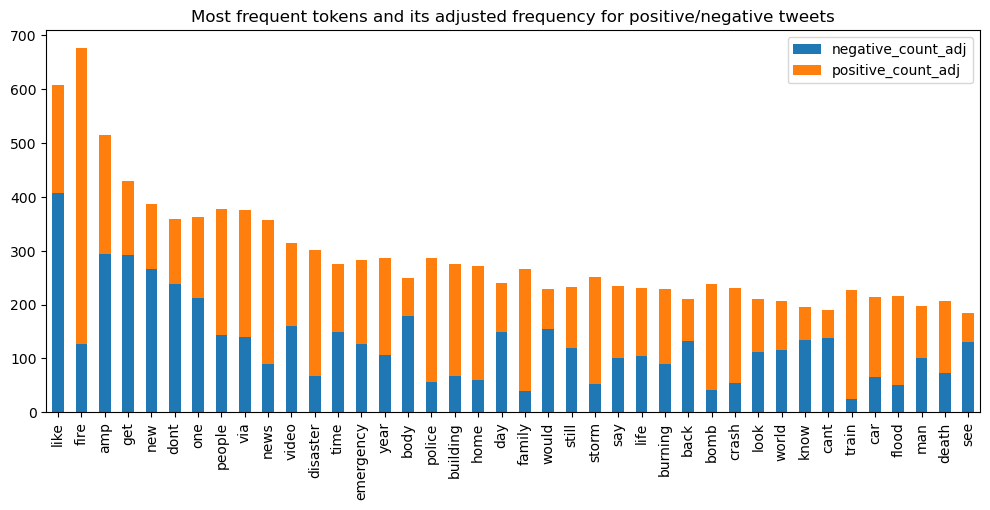

In [12]:
plot_data = df_tokens.sort_values('count_sum', ascending=False).head(n=40)

plot_data.plot(figsize=(10,5), kind='bar', stacked=True, y=['negative_count_adj', 'positive_count_adj'])
plt.tight_layout()
plt.title('Most frequent tokens and its adjusted frequency for positive/negative tweets')
plt.show()


## Stop words statistics and sentiment

Adjust frequency based on negative/possitive distribution

In [13]:
df_stop_words['negative_count_adj'] = df_stop_words['negative_count'] / negative_prop
df_stop_words['positive_count_adj'] = df_stop_words['positive_count'] / positive_prop

df_stop_words['count_sum'] = df_stop_words['negative_count'] + df_stop_words['positive_count']

In [14]:

stop_words_freq_scaler = MinMaxScaler()
stop_words_freq_scaled = stop_words_freq_scaler.fit_transform(df_stop_words[['negative_count_adj', 'positive_count_adj']])

df_stop_words['negative_scaled'] = stop_words_freq_scaled[:,0]
df_stop_words['positive_scaled'] = stop_words_freq_scaled[:,1]

df_stop_words['token_sentiment'] = (2 * df_stop_words['positive_scaled'] / (df_stop_words['negative_scaled'] + df_stop_words['positive_scaled'])) - 1

df_stop_words.head(n=20)

,negative_count,positive_count,negative_count_adj,positive_count_adj,count_sum,negative_scaled,positive_scaled,token_sentiment
the,1701,1212,2978.924080,2825.250766,2913,1.000000,1.000000,0.000000
this,254,160,444.824642,372.970398,414,0.149324,0.132013,-0.061530
and,828,449,1450.058282,1046.648180,1277,0.486772,0.370462,-0.135681
to,1069,683,1872.116309,1592.117387,1752,0.628454,0.563531,-0.054466
it,520,243,910.664622,566.448792,763,0.305703,0.200495,-0.207839
for,441,356,772.313650,829.859136,797,0.259259,0.293729,0.062334
my,488,122,854.623722,284.389929,610,0.286890,0.100660,-0.480531
a,1273,974,2229.377045,2270.457298,2247,0.748383,0.803630,0.035597
be,263,113,460.586145,263.410344,376,0.154615,0.093234,-0.247653
i,973,269,1703.993609,627.056482,1242,0.572016,0.221947,-0.440913


In [15]:
df_stop_words.sort_values('negative_count_adj', ascending=False).head(n=20)

,negative_count,positive_count,negative_count_adj,positive_count_adj,count_sum,negative_scaled,positive_scaled,token_sentiment
the,1701,1212,2978.924080,2825.250766,2913,1.000000,1.000000,0.000000
a,1273,974,2229.377045,2270.457298,2247,0.748383,0.803630,0.035597
to,1069,683,1872.116309,1592.117387,1752,0.628454,0.563531,-0.054466
i,973,269,1703.993609,627.056482,1242,0.572016,0.221947,-0.440913
and,828,449,1450.058282,1046.648180,1277,0.486772,0.370462,-0.135681
of,816,827,1429.042945,1927.790745,1643,0.479718,0.682343,0.174367
in,739,1035,1294.194530,2412.652263,1774,0.434450,0.853960,0.325603
you,607,118,1063.025818,275.065669,725,0.356849,0.097360,-0.571300
is,529,316,926.426125,736.616536,845,0.310994,0.260726,-0.087923
it,520,243,910.664622,566.448792,763,0.305703,0.200495,-0.207839


In [16]:
df_stop_words.sort_values('positive_count_adj', ascending=False).head(n=20)

,negative_count,positive_count,negative_count_adj,positive_count_adj,count_sum,negative_scaled,positive_scaled,token_sentiment
the,1701,1212,2978.924080,2825.250766,2913,1.000000,1.000000,0.000000
in,739,1035,1294.194530,2412.652263,1774,0.434450,0.853960,0.325603
a,1273,974,2229.377045,2270.457298,2247,0.748383,0.803630,0.035597
of,816,827,1429.042945,1927.790745,1643,0.479718,0.682343,0.174367
to,1069,683,1872.116309,1592.117387,1752,0.628454,0.563531,-0.054466
and,828,449,1450.058282,1046.648180,1277,0.486772,0.370462,-0.135681
on,393,373,688.252301,869.487241,766,0.231041,0.307756,0.142383
for,441,356,772.313650,829.859136,797,0.259259,0.293729,0.062334
is,529,316,926.426125,736.616536,845,0.310994,0.260726,-0.087923
at,202,276,353.758180,643.373937,478,0.118754,0.227723,0.314507


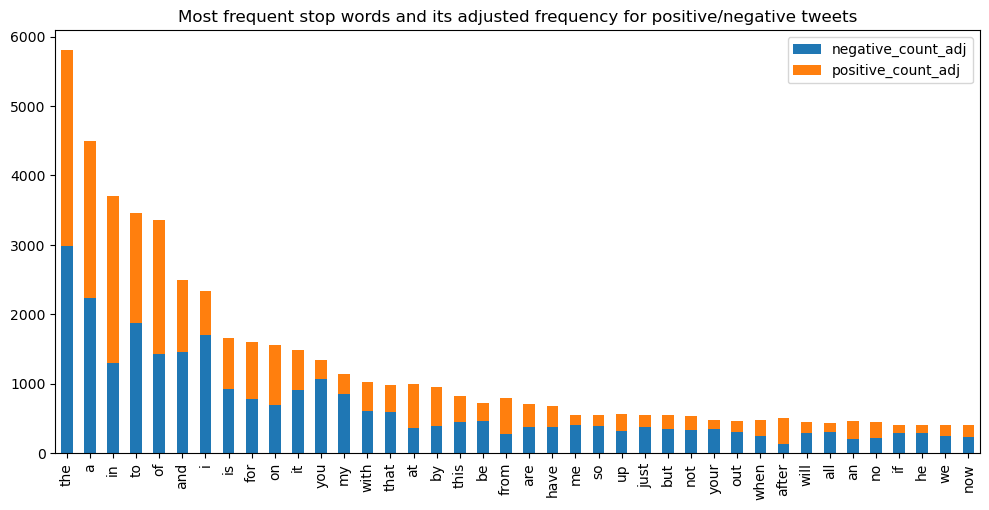

In [17]:
stop_words_plot_data = df_stop_words.sort_values('count_sum', ascending=False).head(n=40)

stop_words_plot_data.plot(figsize=(10,5), kind='bar', stacked=True, y=['negative_count_adj', 'positive_count_adj'])
plt.tight_layout()
plt.title('Most frequent stop words and its adjusted frequency for positive/negative tweets')
plt.show()


## All word tokens

In [18]:
df_all_word_tokens['count_sum'] = df_all_word_tokens['negative_count'] + df_all_word_tokens['positive_count']

Adjust frequency of word tokens considering negative/positive target distribution 

In [19]:
df_all_word_tokens['negative_count_adj'] = df_all_word_tokens['negative_count'] / negative_prop
df_all_word_tokens['positive_count_adj'] = df_all_word_tokens['positive_count'] / positive_prop


Scale frequency, calculate sentiment coefficient based on statistic of all word tokens

In [20]:
word_tokens_freq_scaler = MinMaxScaler()
word_tokens_freq_scaled = word_tokens_freq_scaler.fit_transform(df_all_word_tokens[['negative_count_adj', 'positive_count_adj']])

df_all_word_tokens['negative_scaled'] = word_tokens_freq_scaled[:,0]
df_all_word_tokens['positive_scaled'] = word_tokens_freq_scaled[:,1]

df_all_word_tokens['token_sentiment'] = (2 * df_all_word_tokens['positive_scaled'] / (df_all_word_tokens['negative_scaled'] + df_all_word_tokens['positive_scaled'])) - 1

df_all_word_tokens.head(n=20)

,negative_count,positive_count,count_sum,negative_count_adj,positive_count_adj,negative_scaled,positive_scaled,token_sentiment
serephina,1,0,1,1.751278,0.000000,0.000588,0.000000,-1.000000
the,1701,1212,2913,2978.924080,2825.250766,1.000000,1.000000,0.000000
siren,33,11,44,57.792178,25.641715,0.019400,0.009076,-0.362563
lt3,5,1,6,8.756391,2.331065,0.002939,0.000825,-0.561654
take,55,27,82,96.320297,62.938755,0.032334,0.022277,-0.184151
this,254,160,414,444.824642,372.970398,0.149324,0.132013,-0.061530
china,21,15,36,36.776840,34.965975,0.012346,0.012376,0.001236
get,167,59,226,292.463446,137.532834,0.098178,0.048680,-0.337046
demolished,20,9,29,35.025562,20.979585,0.011758,0.007426,-0.225821
and,828,449,1277,1450.058282,1046.648180,0.486772,0.370462,-0.135681


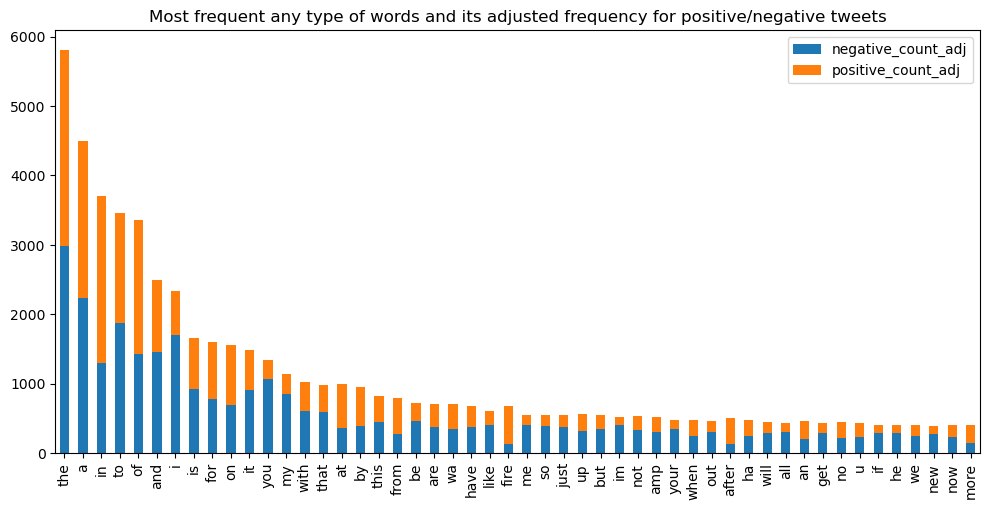

In [21]:
all_words_plot_data = df_all_word_tokens.sort_values('count_sum', ascending=False).head(n=50)

all_words_plot_data.plot(figsize=(10,5), kind='bar', stacked=True, y=['negative_count_adj', 'positive_count_adj'])
plt.tight_layout()
plt.title('Most frequent any type of words and its adjusted frequency for positive/negative tweets')
plt.show()


Save all word tokens sentiment

In [22]:
df_all_word_tokens['token_sentiment'].to_csv('./token-sentiment.csv', index_label='token')

## Punctuations

In [23]:
# adjust frequency of punctuations considering negative/positive target distribution 
df_punctuation['negative_count_adj'] = df_punctuation['negative_count'] / negative_prop
df_punctuation['positive_count_adj'] = df_punctuation['positive_count'] / positive_prop

df_punctuation['count_sum'] = df_punctuation['negative_count'] + df_punctuation['positive_count']

In [24]:
df_punctuation.sort_values('negative_count_adj', ascending=False).head(n=20)

,negative_count,positive_count,negative_count_adj,positive_count_adj,count_sum
/,6060,7010,10612.745399,16340.765567,13070
.,5128,5345,8980.554192,12459.542361,10473
:,2760,3447,4833.527607,8035.181014,6207
?,2135,680,3738.978783,1585.124192,2815
',1873,978,3280.143916,2279.781558,2851
@,1665,834,2915.878067,1944.108200,2499
#,1545,1509,2705.724693,3517.577067,3054
!,750,312,1313.458589,727.292276,1062
-,712,828,1246.910020,1930.121810,1540
_,482,295,844.116053,687.664171,777


In [25]:
df_punctuation.sort_values('positive_count_adj', ascending=False).head(n=20)

,negative_count,positive_count,negative_count_adj,positive_count_adj,count_sum
/,6060,7010,10612.745399,16340.765567,13070
.,5128,5345,8980.554192,12459.542361,10473
:,2760,3447,4833.527607,8035.181014,6207
#,1545,1509,2705.724693,3517.577067,3054
',1873,978,3280.143916,2279.781558,2851
@,1665,834,2915.878067,1944.108200,2499
-,712,828,1246.910020,1930.121810,1540
?,2135,680,3738.978783,1585.124192,2815
!,750,312,1313.458589,727.292276,1062
_,482,295,844.116053,687.664171,777


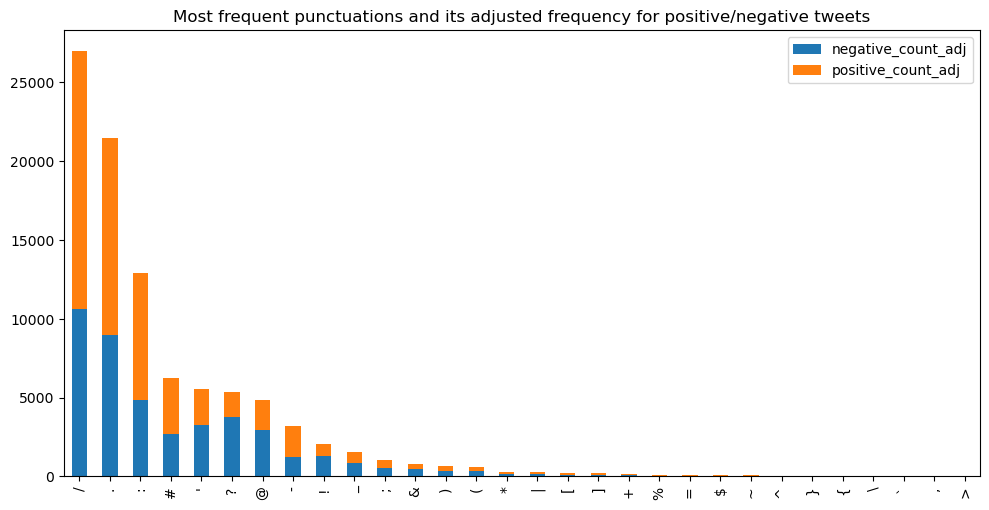

In [26]:
punct_plot_data = df_punctuation.sort_values('count_sum', ascending=False).head(n=40)

punct_plot_data.plot(figsize=(10,5), kind='bar', stacked=True, y=['negative_count_adj', 'positive_count_adj'])
plt.tight_layout()
plt.title('Most frequent punctuations and its adjusted frequency for positive/negative tweets')
plt.show()


**Conslusion**: punctuation is equally distributed accross positive/negative tweets

### Enrich data with different types of sentiment coefficients

In [27]:
df_train.sample(n=10)

,keyword,location,text,target,clean_tokens,stop_words,word_tokens,punctuation
id,,,,,,,,
4844,evacuation,"Renfrew, Scotland",@batfanuk we enjoyed the show today. Great fun...,0,"[enjoyed, show, today, great, fun, emergency, ...","[we, the, the, have, a]","[we, enjoyed, the, show, today, great, fun, th...",@....
1716,bridge%20collapse,NaN,Two giant cranes holding a bridge collapse int...,1,"[two, giant, crane, holding, bridge, collapse,...","[a, into]","[two, giant, crane, holding, a, bridge, collap...",://./
262,ambulance,Amsterdam,http://t.co/7xGLah10zL Twelve feared killed in...,1,[],[],[],://./://./
6278,hijacking,Zimbabwe,Û÷Good SamaritansÛª shot in horror hijacking...,1,"[good, samaritan, shot, horror, hijacking, 263...",[in],"[good, samaritan, shot, in, horror, hijacking,...",://./##
4209,drowned,NaN,@ABCNews24 @PeterDutton_MP \nHe also told you....,0,"[also, told, younoone, drowned, last, year, am...","[he, in, the, had, under, but, not, that]","[he, also, told, younoone, ha, drowned, in, th...",@@_....-&;.'..
3593,desolate,NaN,The Desolate Hope: Part 2: MIRAD: http://t.co/...,0,"[desolate, hope, part, mirad, via]",[the],"[the, desolate, hope, part, mirad, via]",:::://./@
2641,crashed,NaN,I already had my phone updated to 8.4 and some...,0,"[already, phone, updated, somehow, phone, cras...","[i, had, my, to, and, my, and, i, had, to, it,...","[i, already, had, my, phone, updated, to, and,...",.'
8623,seismic,Somalia,Oil and Gas Exploration Takes Seismic Shift in...,1,"[oil, gas, exploration, take, seismic, shift, ...","[and, in, to]","[oil, and, gas, exploration, take, seismic, sh...",-://./#???????#
5459,first%20responders,"Franklin, TN near Nashville",After shooting event at the theater @Starbucks...,1,"[shooting, event, theater, giving, free, coffe...","[after, at, the, is, to, all]","[after, shooting, event, at, the, theater, is,...",@&;.#


In [28]:
def enrich_with_sentiment(df):
    clean_tokens_sentiment = []
    stop_word_sentiment = []
    all_word_tokens_sentiment = []
    for _, row in df.iterrows():
        clean_tokens = row['clean_tokens']
        values_1 = [df_tokens.loc[token, 'token_sentiment'] for token in clean_tokens if token in df_tokens.index]
        s1 = np.sum(values_1) or .0
        clean_tokens_sentiment.append(s1)

        stop_word_tokens = row['stop_words']
        values_2 = [df_stop_words.loc[token, 'token_sentiment'] for token in stop_word_tokens if token in df_stop_words.index]
        s2 = np.sum(values_2) or .0
        stop_word_sentiment.append(s2)

        all_word_tokens = row['word_tokens']
        values_3 = [df_all_word_tokens.loc[token, 'token_sentiment'] for token in all_word_tokens if token in df_all_word_tokens.index]
        s3 = np.sum(values_3) or .0
        all_word_tokens_sentiment.append(s3)
        
    df['clean_tokens_sentiment'] = clean_tokens_sentiment
    df['stop_word_sentiment'] = stop_word_sentiment
    df['all_word_tokens_sentiment'] = all_word_tokens_sentiment


In [29]:
enrich_with_sentiment(df_train)

In [30]:
df_train[['keyword', 'text', 'target', 'clean_tokens_sentiment', 'stop_word_sentiment', 'all_word_tokens_sentiment']].sample(n=30)


,keyword,text,target,clean_tokens_sentiment,stop_word_sentiment,all_word_tokens_sentiment
id,,,,,,
6410,hurricane,@Freegeezy17 you stay in Houston?,0,0.000000,-0.245697,-0.652677
4104,drought,LLF TALK WORLD NEWS U.S. in record hurricane d...,1,2.268785,1.745757,6.151584
4553,emergency%20plan,This from The City of Calgary - \n\nCity of Ca...,1,1.138765,0.620775,6.179598
5867,hailstorm,My favorite text http://t.co/5U5GAkX2ch,0,0.000000,-0.480531,-1.837573
6785,lightning,Yeah tonight I ride the lightning to my final ...,0,-0.609267,-0.975911,-2.486293
6075,heat%20wave,#greatbritishbakeoff love to know where I was ...,0,1.214847,-1.256007,-1.747199
8805,sirens,Yay for sirens,0,-1.000000,0.062334,-1.300229
7296,nuclear%20reactor,Check out this awesome profile on #GE's swimmi...,0,0.564677,0.138946,-1.159767
10872,NaN,Police investigating after an e-bike collided ...,1,0.341937,0.866016,9.412297


## Variables correlation

In [31]:
df_train[['target', 'clean_tokens_sentiment', 'stop_word_sentiment', 'all_word_tokens_sentiment']].corr()

,target,clean_tokens_sentiment,stop_word_sentiment,all_word_tokens_sentiment
target,1.000000,0.370247,0.366810,0.800426
clean_tokens_sentiment,0.370247,1.000000,0.367018,0.528662
stop_word_sentiment,0.366810,0.367018,1.000000,0.568852
all_word_tokens_sentiment,0.800426,0.528662,0.568852,1.000000


**Very high correlation coefficient between all_word_tokens_sentiment and the target!!**

## Predict with sentiment score

In [32]:
def target_predict(df, feature):
    sentiment = df[feature].to_numpy()
    return (sentiment > .0).astype(int)


In [33]:
train_target = df_train['target'].to_numpy()
train_predict = target_predict(df_train, feature='all_word_tokens_sentiment')

true_negatives = len(df_train.query('all_word_tokens_sentiment <= 0 and target == 0'))
true_positives = len(df_train.query('all_word_tokens_sentiment > 0 and target == 1'))
accuracy = (true_negatives + true_positives) / n_samples
f1 = f1_score(train_target, train_predict)
print(f'Accuracy: {accuracy:.3f}, F1: {f1:.3f}')

Accuracy: 0.921, F1: 0.907


** It seems we are able to predict disaster tweets with very high accuracy (0.925) and F1 score (0.911) just by data analysis! :D **

## Predict for Train dataset

In [34]:
df_test = pd.read_csv('./test.csv', index_col='id')
df_test.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [35]:
analyze(df_test, train=False)
enrich_with_sentiment(df_test)

In [36]:
df_test.head()

,keyword,location,text,clean_tokens,stop_words,word_tokens,punctuation,clean_tokens_sentiment,stop_word_sentiment,all_word_tokens_sentiment
id,,,,,,,,,,
0,NaN,NaN,Just happened a terrible car crash,"[happened, terrible, car, crash]","[just, a]","[just, happened, a, terrible, car, crash]",,0.860395,-0.292853,0.972773
2,NaN,NaN,"Heard about #earthquake is different cities, s...","[heard, earthquake, different, city, stay, saf...","[about, is]","[heard, about, earthquake, is, different, city...","#,.",-0.010515,-0.259392,0.739193
3,NaN,NaN,"there is a forest fire at spot pond, geese are...","[forest, fire, spot, pond, goose, fleeing, acr...","[there, is, a, at, are, the, i, them, all]","[there, is, a, forest, fire, at, spot, pond, g...",",,",0.830084,-0.880347,2.665381
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,"[apocalypse, lighting, spokane, wildfire]",[],"[apocalypse, lighting, spokane, wildfire]",.##,0.000000,0.000000,1.879124
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,"[typhoon, soudelor, kill, china, taiwan]","[in, and]","[typhoon, soudelor, kill, in, china, and, taiwan]",,0.565966,0.189922,3.801025


In [38]:
test_predict = target_predict(df_test, feature='all_word_tokens_sentiment')
test_predict[0:20]

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

In [39]:
df_test['target'] = test_predict

In [40]:
df_submission = df_test['target']

In [41]:
df_submission.to_csv('./text-stat-submission.csv')

With this submission F1 score for test dataset is **F1=0.78945** What's a nice surprise!

## Regular scale for sentiment value

The hypotesis why F1 for test is significantly lower than for train test, is that sentiment score for a tweet is built as a sum of individual scores. Therefore the value may be >>1 or <<1. However, we may not have statistics in test set, for some words, therefore the value for test set may be usualy lower, making a bit different scale for the data. Let's try with two options: a) use mean instead of the sum b) let's use words lemmatizing, then we may have higher chance to hit know word in the test set. 

In [42]:
def enrich_with_sentiment_v2(df):
    all_word_tokens_sentiment = []
    for _, row in df.iterrows():
        all_word_tokens = row['word_tokens']
        values_3 = [df_all_word_tokens.loc[token, 'token_sentiment'] for token in all_word_tokens if token in df_all_word_tokens.index]
        s3 = np.mean(values_3) if len(values_3) > 0 else .0
        all_word_tokens_sentiment.append(s3)        
    df['all_word_tokens_sentiment_v2'] = all_word_tokens_sentiment

enrich_with_sentiment_v2(df_train)

In [43]:
df_train.sample(n=10)

,keyword,location,text,target,clean_tokens,stop_words,word_tokens,punctuation,clean_tokens_sentiment,stop_word_sentiment,all_word_tokens_sentiment,all_word_tokens_sentiment_v2
id,,,,,,,,,,,,
1183,blizzard,Waterfront,@Blizzard_draco GIVE ME FREE ART KAMON,0,"[give, free, art, kamon]",[me],"[give, me, free, art, kamon]",@_,0.000000,-0.487191,-2.636125,-0.527225
10201,violent%20storm,New Zealand,Storm batters top half of North Island: A viol...,1,"[storm, batter, top, half, north, island, viol...","[of, a, the]","[storm, batter, top, half, of, north, island, ...",:...://./,0.650024,0.209964,7.822489,0.434583
170,aftershock,dope show,@KJForDays I'm seeing them and Issues at after...,0,"[seeing, issue, aftershock]","[them, and, at]","[im, seeing, them, and, issue, at, aftershock]",@'??,0.864986,-0.076657,-1.750079,-0.250011
8663,sinkhole,NaN,beforeitsnews : A sinkhole grows in Brooklyn: ...,1,"[beforeitsnews, sinkhole, grows, brooklyn, six...","[a, in]","[beforeitsnews, a, sinkhole, grows, in, brookl...",::-_://./)://./,0.688797,0.361200,5.466512,0.546651
426,apocalypse,San Francisco,@alexandrapullin It is indeed. If the apocalyp...,0,"[indeed, apocalypse, come, week, know, ill]","[it, is, if, the, this, i, where, be]","[it, is, indeed, if, the, apocalypse, come, th...",@.':),-1.219484,-1.455770,-3.392072,-0.242291
8609,seismic,NaN,The 08/06/2015 AlabamaQuake seismic summary w/...,1,"[alabamaquake, seismic, summary, earthquake, n...",[the],"[the, alabamaquake, seismic, summary, w, earth...",///##&;://./://./,0.625004,0.000000,3.556814,0.395202
10376,weapons,"( ?å¡ ?? ?å¡),",I liked a @YouTube video from @dannyonpc http:...,0,"[liked, video, battlefield, hardline, new, wea...","[i, a, from]","[i, liked, a, video, from, battlefield, hardli...",@@://./---!,-1.445791,-0.071745,-3.606951,-0.300579
9723,tragedy,India,Railways caught unawares by MP tragedy; Accide...,1,"[railway, caught, unawares, tragedy, accident,...","[by, a, of]","[railway, caught, unawares, by, mp, tragedy, a...",;''-_://./#,0.809259,0.419779,6.291679,0.419445
6534,injuries,California,Enjoying a little golf this summer? Take care ...,1,"[enjoying, little, golf, summer, take, care, a...","[a, this, to, and, can]","[enjoying, a, little, golf, this, summer, take...",?--://./,-3.165643,-0.693026,-1.645160,-0.091398


Corelation check

In [44]:
df_train[['target', 'all_word_tokens_sentiment', 'all_word_tokens_sentiment_v2']].corr()

,target,all_word_tokens_sentiment,all_word_tokens_sentiment_v2
target,1.000000,0.800426,0.817627
all_word_tokens_sentiment,0.800426,1.000000,0.909871
all_word_tokens_sentiment_v2,0.817627,0.909871,1.000000


New feature `all_word_tokens_sentiment_v2` has higher correlation with the target than `all_word_tokens_sentiment`. Let's check the metric on train test set

In [45]:
train_target = df_train['target'].to_numpy()
train_predict = target_predict(df_train, feature='all_word_tokens_sentiment_v2')

true_negatives = len(df_train.query('all_word_tokens_sentiment_v2 <= 0 and target == 0'))
true_positives = len(df_train.query('all_word_tokens_sentiment_v2 > 0 and target == 1'))
accuracy = (true_negatives + true_positives) / n_samples
f1 = f1_score(train_target, train_predict)
print(f'Accuracy: {accuracy:.3f}, F1: {f1:.3f}')

Accuracy: 0.921, F1: 0.907


### Checking stdvar of sentiment score in train and test data sets

count    7613.000000
mean       -0.206866
std         5.061238
min       -16.555732
25%        -3.951152
50%        -1.167861
75%         3.875247
max        14.333143
Name: token_sentiment, dtype: float64

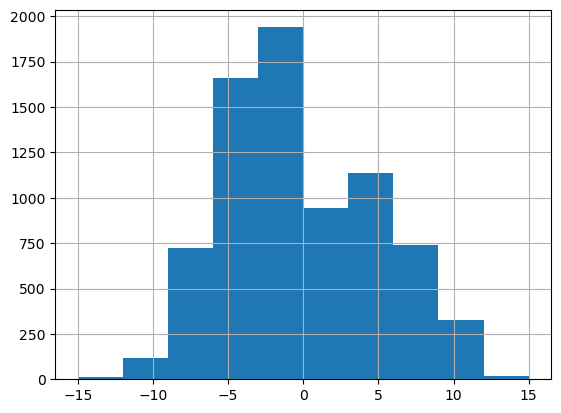

In [46]:
df_train_enriched = pd.read_csv('./train_enriched.csv')
stat1 = df_train_enriched['token_sentiment'].describe()
df_train_enriched['token_sentiment'].hist(range=[-15, 15])
df_train_enriched = None
stat1

count    3263.000000
mean       -0.093004
std         3.839553
min       -12.754731
25%        -2.634554
50%        -0.761093
75%         1.936477
max        13.491895
Name: token_sentiment, dtype: float64

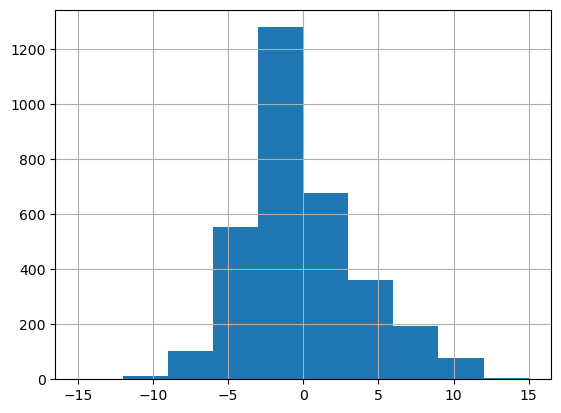

In [47]:
df_test_enriched = pd.read_csv('./test_enriched.csv')
stat2 = df_test_enriched['token_sentiment'].describe()
df_test_enriched['token_sentiment'].hist(range=[-15, 15])
df_test_enriched = None
stat2